In [1]:
import os
import re
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import math

import matplotlib.cm as cm
import matplotlib.pyplot as plt

<jemalloc>: MADV_DONTNEED does not work (memset will be used instead)
<jemalloc>: (This is the expected behaviour if you are running under QEMU)


In [10]:
# Read data from excel. 
fd = 'mops2022data.xlsx'
survey1 = pd.read_excel( fd, sheet_name=0 )

survey1.columns

Index([                                                        'Sample',
                                                          'Response No',
                                  'Low rise  - as opposed to high rise',
                             'Social rent - as opposed to higher rents',
                                                 'Lots of space inside',
              'Accomodates physical disabilities e.g. step-free access',
                    'Family friendly - having units with more bedrooms',
                                                 'Low carbon footprint',
                       'Community spaces e.g. play areas, youth centre',
                                                          'Green space',
                                                                'Other',
                                                       'Please specify',
                                                                      1,
                                                   

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [12]:
import nltk
import spacy
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer

from nltk.corpus import stopwords

from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.tokenize.toktok import ToktokTokenizer

from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer

from nltk import ngrams, FreqDist

lemmatizer = WordNetLemmatizer()
tokenizer = ToktokTokenizer()

In [13]:
import string
import unicodedata
from bs4 import BeautifulSoup
from wordcloud import WordCloud, STOPWORDS

In [14]:
stopword_list = set(stopwords.words('english'))
print(stopword_list)

{'yourselves', 'and', 'into', "couldn't", 'very', 'by', 'i', 'or', 'they', 'its', 'each', 'll', 'after', 'shan', 'hasn', 'isn', 'while', 'aren', "it's", 'herself', 'out', 'ain', 'weren', "mustn't", 'there', "you're", 'needn', 'did', 'about', 'to', 'few', 'over', 'doing', 'mightn', 'my', 'at', 'when', 'off', 'theirs', "don't", 'own', 'how', 'down', 'his', 'ourselves', 'against', 'be', 'some', 'hers', 'does', 'the', 'her', 'has', 'couldn', 'we', 'so', 'just', 'were', 've', 'an', "you'd", 'more', 'now', 'me', 'all', 'until', 'below', 'm', 'from', 'them', 'who', 'most', 'nor', 'their', 't', 'because', 'under', "doesn't", "she's", "haven't", "needn't", "weren't", 'too', 'd', 'of', 'what', 'these', 'can', 'themselves', 'didn', 'once', "isn't", 'itself', 'through', 'it', 's', 'during', 'should', 'ours', 'hadn', 'ma', 'don', 'have', "should've", 'will', 'up', 'any', 'do', 'wouldn', "wouldn't", "you'll", 'myself', 'was', 'y', 'for', "that'll", 'such', 'with', "hadn't", 'haven', 'other', 'in', '

In [15]:
stop = stopwords.words('english')

In [49]:
survey1.columns = survey1.columns.str.replace("'"," ")
survey1.rename(columns={'Why rank':'Why_rank', 
                        '4.Is there anything  weve missed about housing that you would':'more'},inplace=True)

In [63]:
survey1.replace(99, np.nan)
survey1.replace(99.0, np.nan)
survey1.replace('99', np.nan)

,Sample,Response No,Low rise - as opposed to high rise,Social rent - as opposed to higher rents,Lots of space inside,Accomodates physical disabilities e.g. step-free access,Family friendly - having units with more bedrooms,Low carbon footprint,"Community spaces e.g. play areas, youth centre",Green space,...,I live elsewhere in Hackney,I shop at Tesco,I use the car park,I m a member of a local community group,I work in Hackney,I own a local business,I study in Hackney,I have no connection to Hackney,Other.2,Please specify.3
0,1,1,0,1,0,0,1,0,1,0,...,0,1,0,1,1,0,0.0,0,0,0
1,1,2,1,1,0,0,0,1,1,0,...,0,1,0,1,1,0,0.0,0,1,"Kids are here, people want it"
2,1,8,1,1,0,1,1,1,0,1,...,0,0,0,1,1,0,0.0,0,0,0
3,1,10,0,0,0,0,0,0,0,0,...,0,1,1,0,1,0,0.0,0,0,0
4,1,12,0,1,0,0,1,0,1,0,...,0,0,0,0,1,0,0.0,0,1,Lived in Hackney for most of my life
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749,2,616,0,0,0,0,0,1,1,1,...,0,1,0,0,0,0,0.0,0,0,0
750,2,617,1,0,1,0,1,0,0,0,...,0,1,0,0,0,0,0.0,0,0,0
751,2,618,0,0,0,0,0,1,1,1,...,0,1,0,0,0,0,0.0,0,0,0
752,2,623,99,99,99,99,99,99,99,99,...,99,99,99,99,99,99,99.0,99,99,99


In [64]:
# housingfb means 'housing feedback'
housingfb = [('Why_rank', 'more')]
test = pd.DataFrame(housingfb)
test.columns = ['Why_rank', 'more']

In [65]:
test.apply(lambda x: [item for item in x if item not in stop])

Why_rank    [Why_rank]
more                []
dtype: object

In [66]:
survey1.dtypes

Sample                                                              int64
Response No                                                         int64
Low rise  - as opposed to high rise                                 int64
Social rent - as opposed to higher rents                            int64
Lots of space inside                                                int64
Accomodates physical disabilities e.g. step-free access             int64
Family friendly - having units with more bedrooms                   int64
Low carbon footprint                                                int64
Community spaces e.g. play areas, youth centre                      int64
Green space                                                         int64
Other                                                               int64
Please specify                                                     object
NaN                                                                object
NaN                                   

In [67]:
survey1['more'].value_counts()

99                                                                    386
no                                                                     17
No                                                                      9
/                                                                       4
more green space                                                        3
                                                                     ... 
parking                                                                 1
not segregatting by social and high rent for access and facilities      1
children play area                                                      1
parking spaces                                                          1
Building with green plants planted on out wall                          1
Name: more, Length: 328, dtype: int64

In [62]:
survey1['Why_rank'].value_counts()

99                                                                                                      148
lowrise                                                                                                   5
appearance                                                                                                3
Design                                                                                                    3
space                                                                                                     2
                                                                                                       ... 
Number 1 looks more modern and is a personal choice                                                       1
Not interested in sharing with others                                                                     1
Enough space for people without feeling you're on top of each other                                       1
Aesthetic of the building - 

In [80]:
housingfb = survey1.loc[survey1['Why_rank'] != 99]

In [81]:
print(housingfb)

     Sample  Response No  Low rise  - as opposed to high rise  \
0         1            1                                    0   
1         1            2                                    1   
2         1            8                                    1   
3         1           10                                    0   
4         1           12                                    0   
..      ...          ...                                  ...   
697       2          382                                    1   
698       2          384                                    0   
717       2          436                                    0   
730       2          483                                    0   
753       2          251                                    0   

     Social rent - as opposed to higher rents  Lots of space inside  \
0                                           1                     0   
1                                           1                     0   
2     

In [82]:
housingfb['Why_rank'].value_counts()

lowrise                                                                                                 5
Design                                                                                                  3
appearance                                                                                              3
 the design (Aesthetics)                                                                                2
green space                                                                                             2
                                                                                                       ..
Number 1 looks more modern and is a personal choice                                                     1
Not interested in sharing with others                                                                   1
Enough space for people without feeling you're on top of each other                                     1
Aesthetic of the building - how they would fit

<AxesSubplot:>

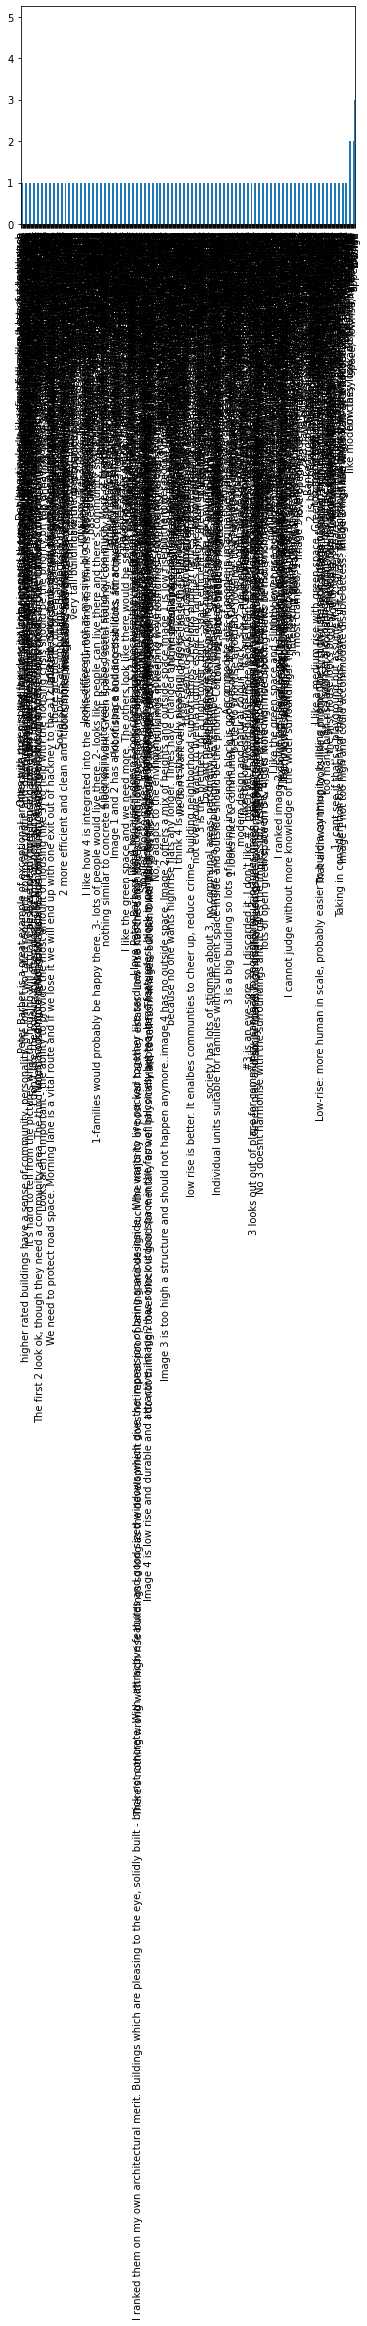

In [83]:
housingfb['Why_rank'].value_counts().sort_values().plot(kind='bar')

In [84]:
housingfb.head(10)

,Sample,Response No,Low rise - as opposed to high rise,Social rent - as opposed to higher rents,Lots of space inside,Accomodates physical disabilities e.g. step-free access,Family friendly - having units with more bedrooms,Low carbon footprint,"Community spaces e.g. play areas, youth centre",Green space,...,I live elsewhere in Hackney,I shop at Tesco,I use the car park,I m a member of a local community group,I work in Hackney,I own a local business,I study in Hackney,I have no connection to Hackney,Other.2,Please specify.3
0,1,1,0,1,0,0,1,0,1,0,...,0,1,0,1,1,0,0.0,0,0,0
1,1,2,1,1,0,0,0,1,1,0,...,0,1,0,1,1,0,0.0,0,1,"Kids are here, people want it"
2,1,8,1,1,0,1,1,1,0,1,...,0,0,0,1,1,0,0.0,0,0,0
3,1,10,0,0,0,0,0,0,0,0,...,0,1,1,0,1,0,0.0,0,0,0
4,1,12,0,1,0,0,1,0,1,0,...,0,0,0,0,1,0,0.0,0,1,Lived in Hackney for most of my life
5,1,16,0,1,0,1,0,0,0,1,...,0,1,0,0,1,0,0.0,0,0,0
6,1,17,0,1,0,0,1,1,0,0,...,0,1,0,0,1,0,0.0,0,0,0
7,1,18,0,0,0,1,0,1,0,1,...,0,0,0,0,1,1,0.0,0,0,0
8,1,19,0,0,0,0,0,0,0,1,...,0,0,0,1,1,0,0.0,0,0,0
9,1,21,0,0,0,0,0,1,1,1,...,0,0,0,1,0,0,0.0,0,0,0


In [85]:
housingfb['Why_rank'].value_counts().head(10)

lowrise                                    5
Design                                     3
appearance                                 3
 the design (Aesthetics)                   2
green space                                2
Aesthetics                                 2
Low Rise                                   2
aesthetics                                 2
space                                      2
how they look and fit with surroundings    2
Name: Why_rank, dtype: int64

In [86]:
morefb = survey1.loc[survey1['more'] != 99]

In [87]:
morefb['more'].value_counts().head(10)

no                                                                     17
No                                                                      9
/                                                                       4
more green space                                                        3
nope                                                                    2
no development                                                          2
communal areas                                                          2
shops in around houses. Local businesses                                1
cost is most important                                                  1
developments that are genuinely co-designed with with the community     1
Name: more, dtype: int64

In [96]:
survey1['Why_ranknew'] = survey1['Why_rank'].str.split(',') 

In [97]:
survey1['Why_ranknew'].value_counts().head(10)

[lowrise]                                                5
[appearance]                                             3
[Design]                                                 3
[like modern classy look,  dislike high rise estates]    2
[space]                                                  2
[I hate highrise]                                        2
[Aesthetics]                                             2
[space,   lowrise,   green areas]                        2
[design]                                                 2
[green space]                                            2
Name: Why_ranknew, dtype: int64

<AxesSubplot:>

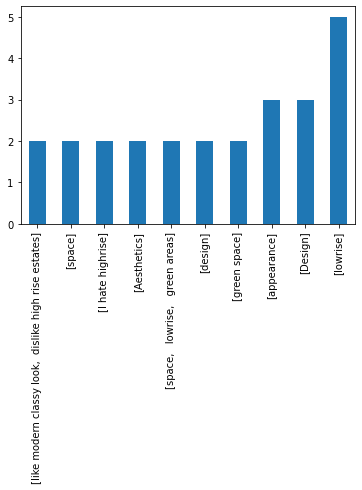

In [98]:
survey1['Why_ranknew'].value_counts().head(10).sort_values().plot(kind='bar')

In [100]:
survey1['more_new'].value_counts().head(10)

[no]                                                                     17
[No]                                                                      9
[/]                                                                       4
[more green space]                                                        3
[nope]                                                                    2
[no development]                                                          2
[communal areas]                                                          2
[shops in around houses. Local businesses]                                1
[cost is most important]                                                  1
[developments that are genuinely co-designed with with the community]     1
Name: more_new, dtype: int64

<AxesSubplot:>

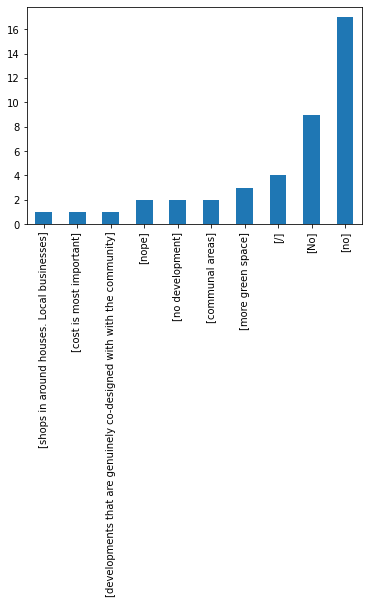

In [101]:
survey1['more_new'] = survey1['more'].str.split(',') 
survey1['more_new'].value_counts().head(10)
survey1['more_new'].value_counts().head(10).sort_values().plot(kind='bar')